<a href="https://colab.research.google.com/github/anmolkhurana490/Sign-Language-Translator/blob/main/model_training/word_level_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing and Importing Necessary Libraries

In [ ]:
import torch
import numpy as np
import os
import json

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Data Importing from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Preprocessing and Loading

In [ ]:
word_data_path = '/content/Sign-Language-Translator/Frames_Word_Level'

In [ ]:
def load_json(json_path):
  with open(json_path, 'r') as f:
    return json.load(f)

classes = load_json('/content/drive/MyDrive/Sign-Language-Translator/data/word_class_names.json')
num_classes = len(classes)
print("Number of classes:", num_classes)

Number of classes: 114


In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class_to_label = {class_name: i for i, class_name in enumerate(classes)}
label_to_class = {i: class_name for i, class_name in enumerate(classes)}

In [ ]:
def load_saved_data(data_path, train_data):
  if not os.path.exists(data_path):
    return []

  data_type = 'train' if train_data else 'test'
  features, labels = torch.load(data_path)[data_type]
  return list(zip(features, labels))

In [ ]:
data_path = '/content/drive/MyDrive/Sign-Language-Translator/data/preprocessed_word_level_data.pth'
# data = load_saved_data(data_path, True)
# data[0][0].shape, data[0][1]

In [ ]:
class HandGestureDataset(Dataset):
    def __init__(self, saved_data_path='', train_data=False):
        self.cache = dict(enumerate(load_saved_data(saved_data_path, train_data)))

    def __len__(self):
        return len(self.cache)

    def __getitem__(self, idx):
        cached_data = self.cache[idx]
        features, label = cached_data
        return features.to(torch.float32), class_to_label[label]

def collate_fn(batch):
  batch = list(filter(lambda x: x[0] is not None, batch))
  images, label = zip(*batch)
  return torch.stack(images), torch.tensor(label)

In [ ]:
train_dataset = HandGestureDataset(saved_data_path=data_path, train_data=True)
test_dataset = HandGestureDataset(saved_data_path=data_path, train_data=False)

In [ ]:
len(train_dataset), len(test_dataset)

(26839, 207)

In [ ]:
train_dataset[6][0].shape

torch.Size([67, 4])

In [ ]:
# Create DataLoaders for the training and testing datasets
# Set num_workers to 0 to avoid CUDA re-initialization issues with multiprocessing
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False, collate_fn=collate_fn)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 26839
Testing dataset size: 207


In [ ]:
for x_batch, y_batch in train_dataloader:
  print("Features data shape:", x_batch.shape, "Label:", y_batch.shape)
  # break

Features data shape: torch.Size([1024, 67, 4]) Label: torch.Size([1024])
Features data shape: torch.Size([1024, 67, 4]) Label: torch.Size([1024])
Features data shape: torch.Size([1024, 67, 4]) Label: torch.Size([1024])
Features data shape: torch.Size([1024, 67, 4]) Label: torch.Size([1024])
Features data shape: torch.Size([1024, 67, 4]) Label: torch.Size([1024])
Features data shape: torch.Size([1024, 67, 4]) Label: torch.Size([1024])
Features data shape: torch.Size([1024, 67, 4]) Label: torch.Size([1024])
Features data shape: torch.Size([1024, 67, 4]) Label: torch.Size([1024])
Features data shape: torch.Size([1024, 67, 4]) Label: torch.Size([1024])
Features data shape: torch.Size([1024, 67, 4]) Label: torch.Size([1024])
Features data shape: torch.Size([1024, 67, 4]) Label: torch.Size([1024])
Features data shape: torch.Size([1024, 67, 4]) Label: torch.Size([1024])
Features data shape: torch.Size([1024, 67, 4]) Label: torch.Size([1024])
Features data shape: torch.Size([1024, 67, 4]) Labe

In [ ]:
for x_batch, y_batch in test_dataloader:
  print("Features data shape:", x_batch.shape, "Label:", y_batch.shape)
  # break

Features data shape: torch.Size([207, 67, 4]) Label: torch.Size([207])


Model Building and Training

In [ ]:
from torch import nn

In [ ]:
class MyModel(nn.Module):
  def __init__(self, input_size, hidden_sizes, dropout_rates, output_size):
    super().__init__()

    classifier_layers = [nn.Flatten()]

    for size, rate in zip(hidden_sizes, dropout_rates):
      classifier_layers.extend([
          nn.Linear(input_size, size),
          nn.BatchNorm1d(size),
          nn.ReLU(),
          nn.Dropout(rate)
      ])

      input_size = size

    classifier_layers.append(nn.Linear(input_size, output_size))

    self.classifier = nn.Sequential(*classifier_layers)


  def forward(self, x):
    out = self.classifier(x)
    return out

In [ ]:
learning_rate = 1e-3

epochs = 200
batch_size = 1024
steps_per_epoch = len(train_dataloader)

num_nodes = 21 + 21 + 25
# input_size = 64 * 64
output_size = num_classes

in_channels = 3

In [ ]:
def evaluate(model, data_loader, num_nodes, in_channels, total_size, batch_size, criterion):
  model.eval()
  total_correct = 0
  total_loss = 0

  with torch.no_grad():
    for features, labels in data_loader:
      features, labels = features[:, :num_nodes, :in_channels].to(device), labels.to(device)

      outputs = model(features)
      loss = criterion(outputs, labels)
      total_loss += loss.item()

      _, predicted = torch.max(outputs, 1)

      total_correct += (predicted == labels).sum().item()

      # del features, labels
      # torch.cuda.empty_cache()
      # gc.collect()

  accuracy = total_correct / total_size
  avg_loss = total_loss / len(data_loader)
  return avg_loss, accuracy

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

model = MyModel(
    in_channels * num_nodes,
    # [2048, 960], [0.3, 0.3],
    [1472, 3520], [0.2, 0.2],
    output_size
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)

scheduler = OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=steps_per_epoch, epochs=epochs)

model = model.to(device)

In [ ]:
model.train()

MyModel(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=201, out_features=1472, bias=True)
    (2): BatchNorm1d(1472, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=1472, out_features=3520, bias=True)
    (6): BatchNorm1d(3520, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=3520, out_features=114, bias=True)
  )
)

In [ ]:
train_losses = []
test_losses = []

for epoch in range(epochs):
  total_loss = 0

  for features, labels in train_dataloader:
    model.train()
    features, labels = features[:, :num_nodes, :in_channels].to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = model(features)

    loss = criterion(outputs, labels)
    total_loss += loss.item()

    # del features, labels
    # torch.cuda.empty_cache()
    # gc.collect()

    loss.backward()
    optimizer.step()
    scheduler.step()

  train_losses.append(total_loss/len(train_dataloader))

  test_loss, _ = evaluate(model, test_dataloader, num_nodes, in_channels, len(test_dataset), batch_size, criterion)
  test_losses.append(test_loss)

  print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss/steps_per_epoch}, LR: {scheduler.get_last_lr()[0]}")

Epoch 1/200, Loss: 4.473265965779622, LR: 4.065863601199562e-05
Epoch 2/200, Loss: 4.042995611826579, LR: 4.2632736542164845e-05
Epoch 3/200, Loss: 3.818350668306704, LR: 4.591688403342211e-05
Epoch 4/200, Loss: 3.648067968863028, LR: 5.050206574490725e-05
Epoch 5/200, Loss: 3.4959304244429976, LR: 5.6375698485800776e-05
Epoch 6/200, Loss: 3.3338010134520353, LR: 6.352166314758424e-05
Epoch 7/200, Loss: 3.1692130212430603, LR: 7.192034893997962e-05
Epoch 8/200, Loss: 3.0098040015609175, LR: 8.154870720916913e-05
Epoch 9/200, Loss: 2.8459612440179893, LR: 9.238031469060092e-05
Epoch 10/200, Loss: 2.6797915917855724, LR: 0.00010438544602279522
Epoch 11/200, Loss: 2.5325819386376276, LR: 0.00011753115532315173
Epoch 12/200, Loss: 2.3894759813944497, LR: 0.0001317813666018849
Epoch 13/200, Loss: 2.2737576255091914, LR: 0.00014709697276596727
Epoch 14/200, Loss: 2.157375353353995, LR: 0.00016343594294137686
Epoch 15/200, Loss: 2.0586744061222784, LR: 0.00018075343781912825
Epoch 16/200, Los

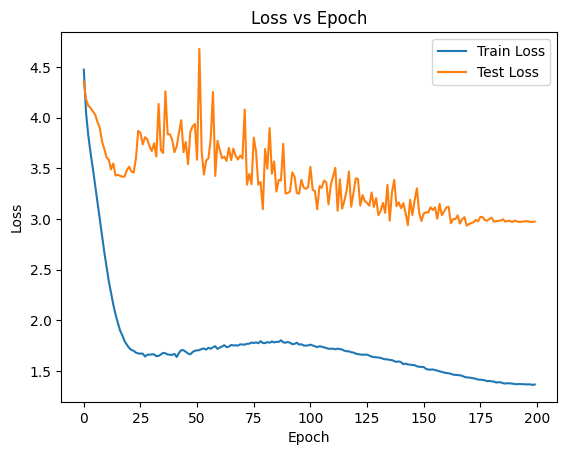

In [ ]:
# Loss Visualization over Epochs
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch')
plt.show()

Model Evaluation and Predction

In [ ]:
test_loss, test_accuracy = evaluate(model, test_dataloader, num_nodes, in_channels, len(test_dataset), 256, criterion)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 2.9747917652130127
Test Accuracy: 0.3864734299516908


In [ ]:
train_loss, train_accuracy = evaluate(model, train_dataloader, num_nodes, in_channels, len(train_dataset), 256, criterion)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")

Train Loss: 1.2941197686725192
Train Accuracy: 0.9107269272327583


Saving the Model

In [ ]:
import os

# Create the directory if it doesn't exist
save_directory = '/content/drive/MyDrive/Sign-Language-Translator/saved_models'
os.makedirs(save_directory, exist_ok=True)

# Save the entire model with .pth extension
model_path = os.path.join(save_directory, 'word_level_model_states_v3.pth')
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/Sign-Language-Translator/saved_models/word_level_model_states_v3.pth


Hyperparameter Tuning using Optuna

In [ ]:
!pip install optuna

In [ ]:
import optuna

In [ ]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())

In [ ]:
study = torch.load('/content/drive/MyDrive/Sign-Language-Translator/saved_models/optuna_word_study.pth', weights_only=False)

In [ ]:
# objective function
def objective(trail):
  # hyperparameter vaue from search space
  num_hidden_layers = trail.suggest_int('num_hidden_layers', 1, 4)

  # learning_rate = trail.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
  # weight_decay = trail.suggest_float('weight_decay', 1e-4, 1e-2, log=True)
  # batch_size = trail.suggest_categorical('batch_size', [256, 512, 1024])
  # optimizer_name = trail.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSProp'])
  # epochs = trail.suggest_int('epochs', 80, 150)

  in_channels = 3
  num_nodes = 67
  epochs = 100
  optimizer_name = 'Adam'
  learning_rate = 1e-3
  weight_decay = 0.005
  batch_size = 1024

  hidden_neurons, dropout_rates = [], []
  for _ in range(num_hidden_layers):
    hidden_neurons.append(trail.suggest_int(f'hidden_neurons_{_}', 64, 5120, step=64))
    dropout_rates.append(trail.suggest_float(f'dropout_rate_{_}', 0.0, 0.5, step=0.05))

  # model initialize
  model = MyModel(in_channels*num_nodes, hidden_neurons, dropout_rates, output_size)
  model.to(device)

  # params initialize
  criterion = nn.CrossEntropyLoss()

  # create data loader
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

  # select optimizer
  # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  if optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  scheduler = OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=epochs)

  # training loop
  for epoch in range(epochs):
    for x_batch, y_batch in train_loader:
      x_batch, y_batch = x_batch[:, :num_nodes, :in_channels].to(device), y_batch.to(device)
      y_pred = model(x_batch)

      loss = criterion(y_pred, y_batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      scheduler.step()

  # evauation
  model.eval()
  _, accuracy = evaluate(model, test_loader, num_nodes, in_channels, len(test_dataset), batch_size, criterion)

  # return accuracy
  return accuracy

In [ ]:
study.optimize(objective, n_trials=30)

In [ ]:
torch.save(study, '/content/drive/MyDrive/Sign-Language-Translator/saved_models/optuna_word_study.pth')

In [ ]:
study.best_params

In [ ]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_contour

In [ ]:
plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

In [ ]:
plot_parallel_coordinate(study, params=list(study.best_params.keys()))
# learning rate = 0.001
# weight decay = 0.008
# batch size = 1024
# num_hidden_layers = 4
# num neurons = 1000 - 3000
# dropout = 0.0 - 0.4

Load and Predict Model

In [ ]:
import time

In [ ]:
save_directory = '/content/drive/MyDrive/Sign-Language-Translator/saved_models'
model_path = os.path.join(save_directory, 'word_level_model_states_v3.pth')

model = MyModel(
    in_channels * num_nodes,
    [1472, 3520], [0.2, 0.2],
    output_size
)
model.to(device)

model.load_state_dict(torch.load(model_path))
model.eval()

MyModel(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=201, out_features=1472, bias=True)
    (2): BatchNorm1d(1472, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=1472, out_features=3520, bias=True)
    (6): BatchNorm1d(3520, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=3520, out_features=114, bias=True)
  )
)

In [ ]:
def predict_gloss(model, x):
  x = x.unsqueeze(0).to(device)

  with torch.no_grad():
    out = model(x)
    out = nn.functional.sigmoid(out)

  val, ypred = torch.max(out, 1)
  return ypred

In [ ]:
# measuring time
start = time.time()

ypred = predict_gloss(model, test_dataset[4][0][:num_nodes, :in_channels])
print("Predicted Gloss:", label_to_class[ypred.item()])

print(f"Time taken: {time.time() - start}")

Predicted Gloss: FEVER
Time taken: 0.003254413604736328
